# Bayesian Data analysis: Seminar III

$\textbf{Today's Outline}$:

- Model comparison:
    - Occam's Razor
    - Fitting a polynomial: Overfitting and Underfitting
    - Bayesian model comparison: Bayes Factor, BIC, AIC
- Different MCMC Algorithms:
    - Rejection Sampling
    - Gibbs Sampling
    - Slice Sampling
    - Hamiltonian Monte Carlo
    - Ensemble Samplers

## Model Comparison

Example from David Mackay's $\textit{Information Theory, Inference, and Learning Algorithms}$.

$\textbf{Question:}$ How many boxes are there in the picture?

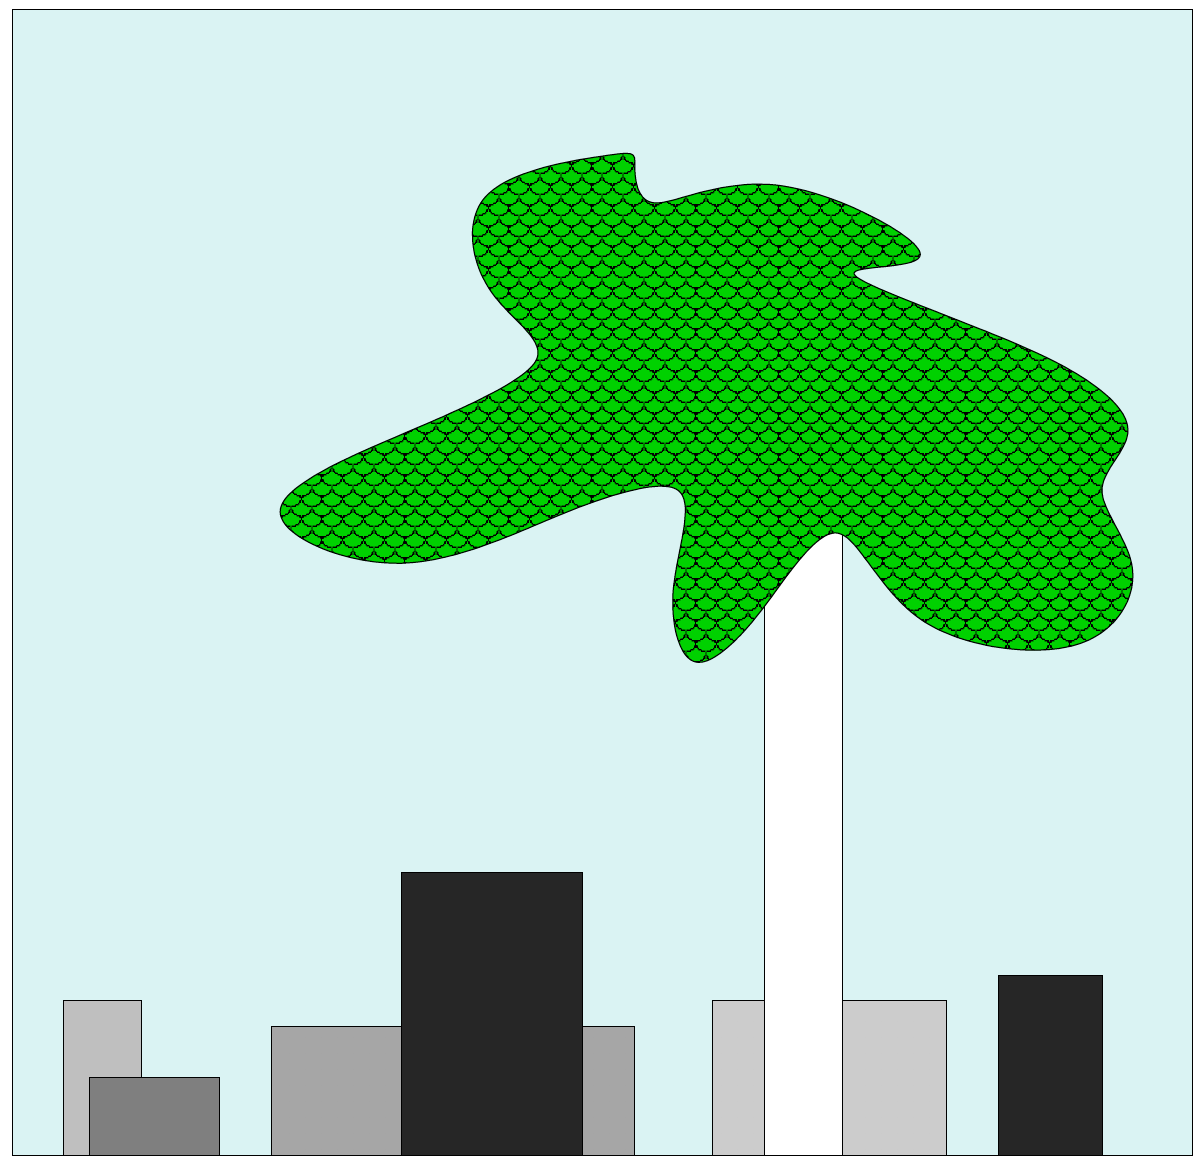

In [1]:
from IPython.display import Image

Image("./mackay1.png",width=600,height=600)

Possibility 1:

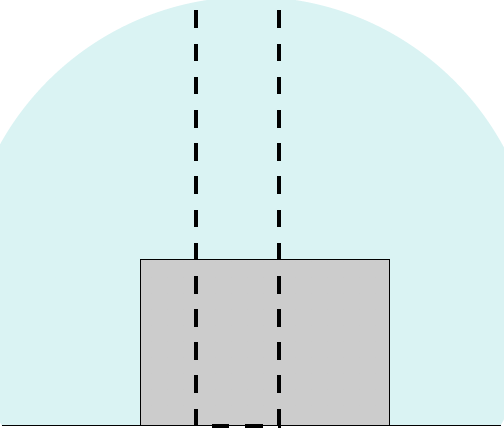

In [2]:
Image("./possibility1.png")

Possibility 2:

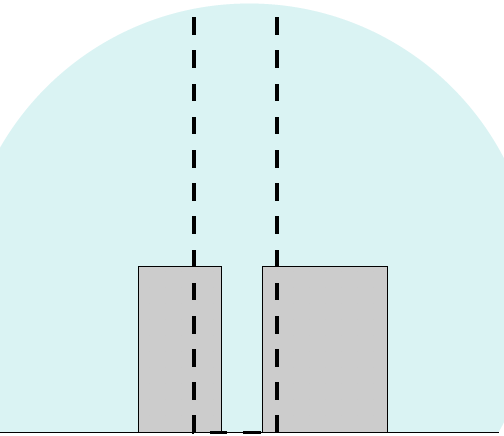

In [3]:
Image("./possibility2.png")

Intuitively, the second possibility seems a bit contrived. You require two boxes of the exact same height, looks, etc. to explain when Possibility 1 explains the same picture in terms of one box.

$\textbf{Occam's razor}:$ Philosophical principle that states that, "of two competing theories, the simpler explanation of an entity is to be preferred". The term razor refers to distinguishing between two hypotheses either by "shaving away" unnecessary assumptions or cutting apart two similar conclusions. Note that Occam's razor is just a philosophical principle (although an appealing one).

We hope that any method we would use for comparing models build this intuition in its mathematics.

### Example: Fitting a cubic relation with polynomials

In our example, we will create a mock data using a cubic relation + Gaussian noise. We will then try to fit the data with polynomials of different orders (differing complexity). We will then introduce some quantities to compare the different models

Let us start by creating a mock data drawn from a cubic relation, 

\begin{equation}
    y = x^3 - x^2 - x + 1 + \epsilon,
\end{equation}

where, $\epsilon$ is a Gaussian noise with unit variance.

In [4]:
# Import the essential packages
import numpy as np
import matplotlib.pyplot as plt

# Latexify your plots

plt.rc('text',usetex=True)
plt.rc('font',family='serif')

FONTSIZE = 13

In [5]:
a0, a1, a2, a3 = 1., -1., -1., 1.
N_DATA = 20
x_data = np.random.uniform(-2.,1.5, N_DATA)
y_data = a3 * x_data**3 + a2 * x_data**2 + a1 * x_data  + a0 + 1. * np.random.normal(size=N_DATA)

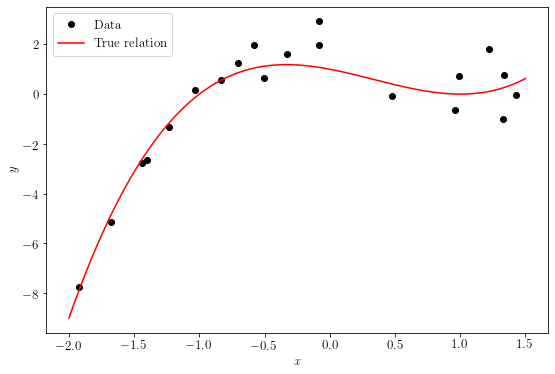

In [6]:
# Plot the mock data

plt.figure(figsize=(9,6))

x_plot = np.linspace(-2., 1.5, 1000)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('$x$', fontsize=FONTSIZE)
plt.ylabel('$y$', fontsize=FONTSIZE)
plt.plot(x_data, y_data, 'o', color='k', label='Data')
plt.plot(x_plot, a3 * x_plot**3 + a2 * x_plot**2 + a1 * x_plot  + a0, 'r',label='True relation')
plt.legend(fontsize=FONTSIZE)
plt.show()

Now fit the data with polynomials of different degree, 

\begin{equation}
    p_n(x) = \sum_{i=0}^{n}a_n x^n
\end{equation}

So our models for the data are the polynomials of degree, $n$. Let us denote this with, $\mathcal{M}_n$. We want to know which model explains the data the best.

First, let us find the maximum likelihood solution for fitting the model, $\mathcal{M}_n$. For this exercise, we will simply maximize over the log-likelihood, not sample from the posterior.

In [7]:
from scipy.optimize import fmin_powell

In [8]:
def polyfit_ln_likelihood(theta, order, x_data, y_data):
    y_model = np.zeros(len(x_data))
    if(order==0):
        y_model = theta
    else:
        for i in range(order+1):
            y_model += theta[i]* (x_data**i)
    return -np.sum(-0.5*(y_model - y_data)**2)

In [9]:
from samplers.AdaptiveMH import Adaptive_MH_sampler

In [10]:
orders = np.arange(1,10)

opt_value_list = []
max_lkl = []
for ORDER in orders:
    print("Fitting polynomial of order: %d"%(ORDER))
    starting_pos = np.zeros(ORDER + 1)
    opt_value = fmin_powell(polyfit_ln_likelihood, starting_pos, args=(ORDER, x_data, y_data))
    opt_value_list.append(opt_value)
    max_lkl.append(-polyfit_ln_likelihood(opt_value, ORDER, x_data, y_data))

Fitting polynomial of order: 1
Optimization terminated successfully.
         Current function value: 45.401617
         Iterations: 3
         Function evaluations: 88
Fitting polynomial of order: 2
Optimization terminated successfully.
         Current function value: 8.828863
         Iterations: 5
         Function evaluations: 199
Fitting polynomial of order: 3
Optimization terminated successfully.
         Current function value: 4.902041
         Iterations: 7
         Function evaluations: 351
Fitting polynomial of order: 4
Optimization terminated successfully.
         Current function value: 4.778112
         Iterations: 15
         Function evaluations: 808
Fitting polynomial of order: 5
Optimization terminated successfully.
         Current function value: 4.658726
         Iterations: 14
         Function evaluations: 834
Fitting polynomial of order: 6
Optimization terminated successfully.
         Current function value: 4.096525
         Iterations: 15
         Function 

In [11]:
# Plot the maximum likelihood solution

def posterior_predictive_plot(ax, theta_ML, x_data, y_data):
    x_plot = np.linspace(-2.,1.5,1000)
    N_ORDER = len(theta_ML)
    y_pred = np.zeros(len(x_plot))
    for i in range(N_ORDER):
        y_pred += theta_ML[i] * x_plot**i

    ax.set_ylim(-8, 5)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$y$', fontsize=FONTSIZE)
    ax.plot(x_data, y_data, 'o', color='k', label='Data')
    ax.plot(x_plot, a3 * x_plot**3 + a2 * x_plot**2 + a1 * x_plot  + a0, 'r',label='True relation')
    ax.plot(x_plot, y_pred, 'b',label='Max. Likelihood relation (Order: %d)'%(N_ORDER - 1))
    ax.legend(loc='lower right', fontsize=FONTSIZE)  

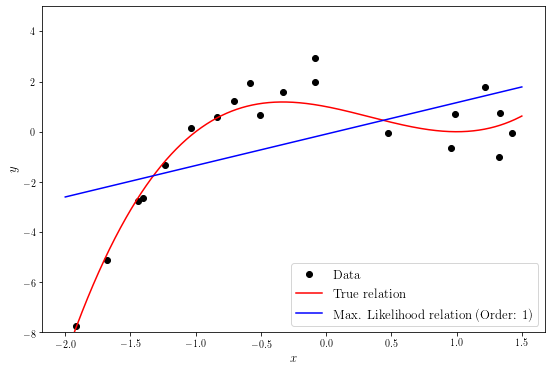

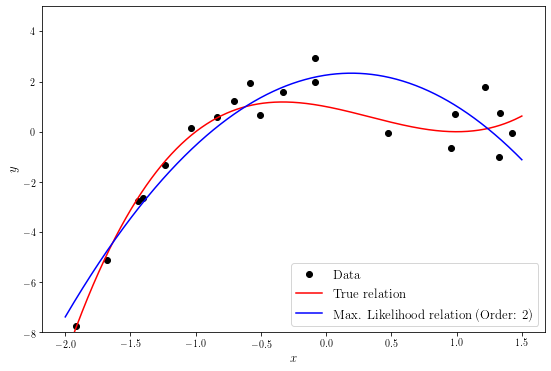

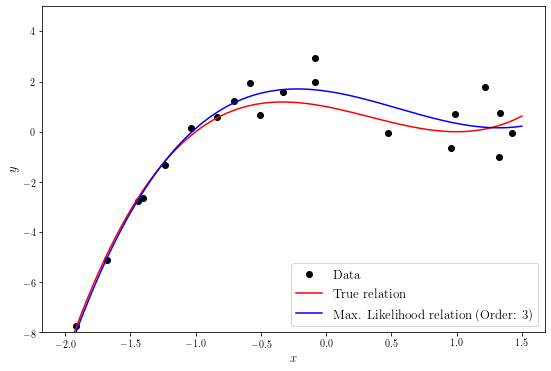

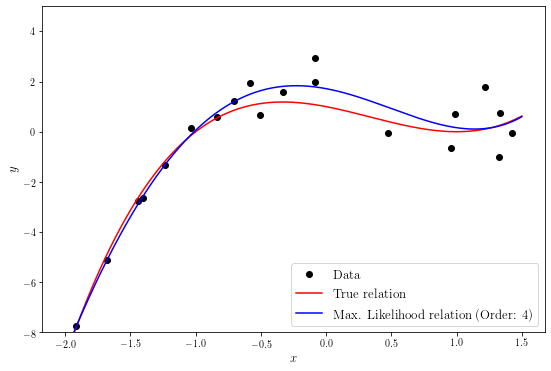

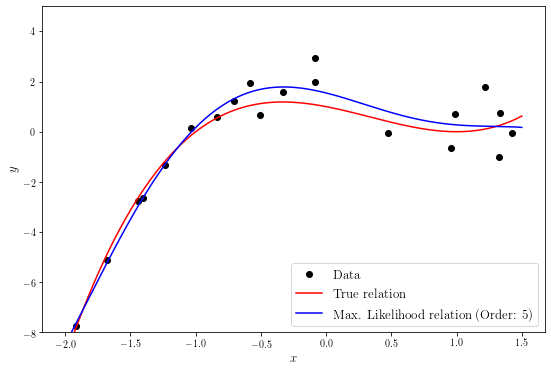

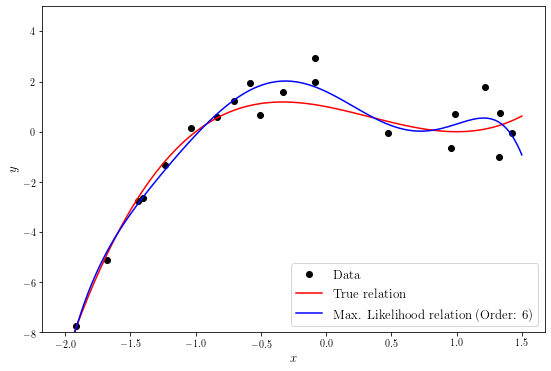

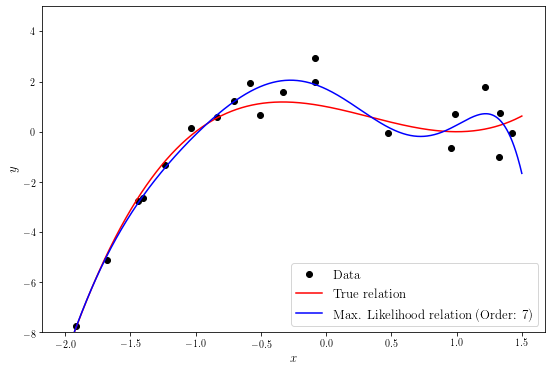

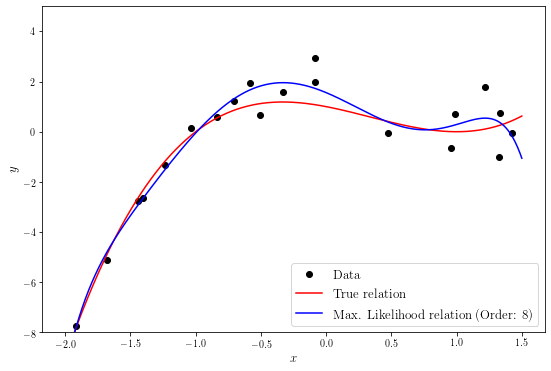

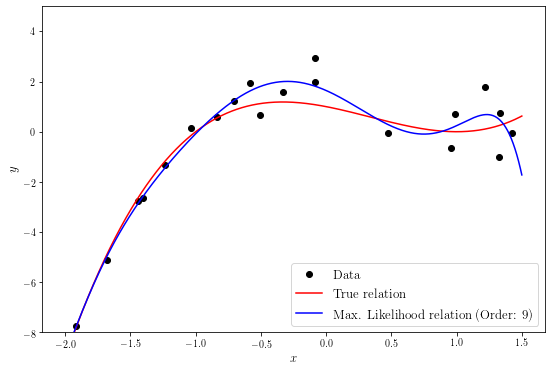

In [12]:
for theta_ML in opt_value_list:
    fig, ax = plt.subplots(1,1,figsize=(9,6))
    posterior_predictive_plot(ax, theta_ML, x_data, y_data)
    plt.show()

Underfitting and Overfitting:

$\textit{Underfitting}$: The model being fitted is not complex enough to fit the data.

$\textit{Overfitting}$: The model being fitted is too complex. Complex beyond necessity. It learns from the noise.

When overfitted or underfitted, the models do not generalizes well. 

Some methods of checking this (which we won't go into):

$\textit{Cross-validation}$: Fit the model on a sub-set of the data and check the validity with the rest of the data.

In [13]:
N_TEST = 100

x_test = np.random.uniform(-2.,1.5, N_TEST)
y_test = a3 * x_test**3 + a2 * x_test**2 + a1 * x_test  + a0 + 1. * np.random.normal(size=N_TEST)

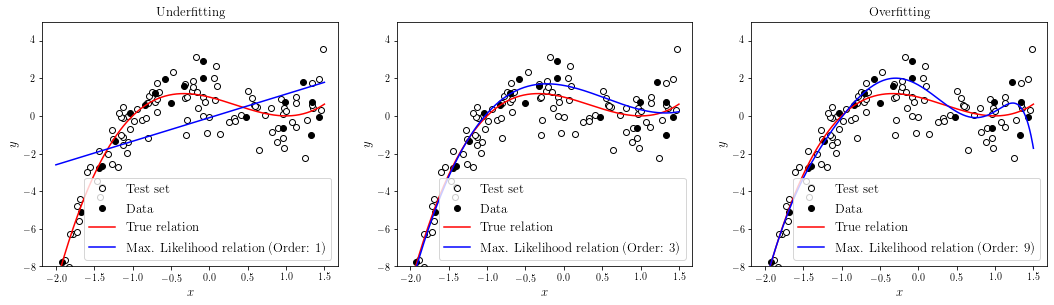

In [14]:
fig, ax = plt.subplots(1,3,figsize=(18,4.5))

ax[0].set_title('Underfitting', fontsize=FONTSIZE)
ax[2].set_title('Overfitting', fontsize=FONTSIZE)

for i in range(3):
    ax[i].plot(x_test, y_test, 'ko', markerfacecolor='white', label='Test set')
posterior_predictive_plot(ax[0], opt_value_list[0], x_data, y_data)
posterior_predictive_plot(ax[1], opt_value_list[2], x_data, y_data)
posterior_predictive_plot(ax[2], opt_value_list[-1], x_data, y_data)

plt.show()

In [15]:
def generalized_error(theta_ML, x_test, y_test):
    N_ORDER = len(theta_ML)
    y_pred = np.zeros(len(x_test))
    for i in range(N_ORDER):
        y_pred += theta_ML[i] * x_test**i
    return np.sum((y_pred - y_test)**2)

In [16]:
generalized_error_arr = np.zeros(len(orders))

for i, theta_ML in enumerate(opt_value_list):
    generalized_error_arr[i] = generalized_error(theta_ML, x_test, y_test)

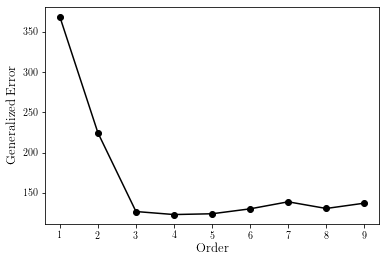

In [17]:
plt.xlabel('Order', fontsize=FONTSIZE)
plt.ylabel('Generalized Error', fontsize=FONTSIZE)
plt.plot(orders, generalized_error_arr, 'ko-')
plt.show()

#### Bayesian Model Comparison

Given two models, $\mathcal{M}_1$ and  $\mathcal{M}_2$ to describe a data set, $D$, which model is preferred?

What we want is the posterior probability ratios, 

\begin{equation}
    \frac{\mathcal{P}(\mathcal{M}_1|D)}{\mathcal{P}(\mathcal{M}_2|D)} = \frac{\mathcal{P}(D|\mathcal{M}_1)}{\mathcal{P}(D|\mathcal{M}_2)}\frac{\mathcal{P}(\mathcal{M}_1)}{\mathcal{P}(\mathcal{M}_2)}.
\end{equation}

The quantity $\frac{\mathcal{P}(D|\mathcal{M}_1)}{\mathcal{P}(D|\mathcal{M}_2)}$ is called the Bayes factor.

However, $\mathcal{P}(D|\mathcal{M})$ is what is known as the $\textit{evidence}$ and is notoriously difficult to evaluate.

\begin{equation}
    \mathcal{P}(D|\mathcal{M}) = \int \mathcal{P}(D|\theta, \mathcal{M}) \mathcal{P}(\theta|\mathcal{M})d\theta
\end{equation}

Nevertheless, one can make simplifications based on some assumption. For example, if one uses $\textit{Laplace Approximation}$, i.e., assume a Taylor expansion around the maximum likelihood estimate. In addition to this if one assumes, the number of data points, $N \rightarrow \infty$, one arrives at the quantity known as the $\textit{Bayesian Information Criterion}$ (BIC),

\begin{equation}
    \textrm{BIC} = - 2\ln\mathcal{L} + k \ln N,
\end{equation}

where, $k$ is the number of parameters fit, $N$ is the total number of data points.

Under the above mentioned approximations (Laplace approx and $N \rightarrow \infty$), $\mathcal{P}(D|\mathcal{M}) \approx \exp(-\textrm{BIC}/2)$.

A related quantity is the $\textit{Aikake Information Criterion}$ (AIC) which is defined as,

\begin{equation}
    \textrm{AIC} = - 2\ln\mathcal{L} + 2k\bigg(\frac{N}{N - k - 1}\bigg).
\end{equation}

For both AIC and BIC, the term containing $k$ is an Occam's razor factor. It penalizes a model for having more parameters. For adding a new parameter, the change in likelihood must be outweigh this Occam's razor factor. Model with smaller AIC/BIC is preferred. 

Let us now look at the AIC and BIC for the polynomial fits we did before (Although strictly speaking, using BIC for this small data set is not right. Here, we do it just for demonstration.)

In [18]:
def bic(max_lnL, N_DIM, N_DATA):
    return N_DIM * np.log(N_DATA) - 2*max_lnL

def aic(max_lnL, N_DIM, N_DATA):
    return 2 * N_DIM * (N_DATA / (N_DATA - N_DIM - 1)) - 2*max_lnL

In [19]:
bic_arr = np.zeros(len(orders))
aic_arr = np.zeros(len(orders))
i = 0
for order, max_lnL in zip(orders, max_lkl):
    bic_arr[i] = bic(max_lnL, order+1, N_DATA)
    aic_arr[i] = aic(max_lnL, order+1, N_DATA)
    i += 1

In [21]:
np.log(100)

4.605170185988092

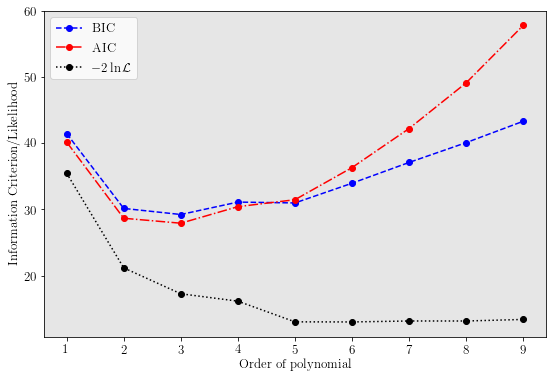

In [20]:
fig = plt.figure(figsize=(9,6))

plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

fig.axes[0].set_facecolor((0.9, 0.9, 0.9))

plt.xlabel('Order of polynomial', fontsize=FONTSIZE)
plt.ylabel('Information Criterion/Likelihood', fontsize=FONTSIZE)
plt.plot(orders, bic_arr, 'bo--', label='BIC')
plt.plot(orders, aic_arr, 'ro-.', label='AIC')
plt.plot(orders, -2*np.array(max_lkl), 'ko:', label='$-2\ln\mathcal{L}$')
plt.legend(fontsize=FONTSIZE)
plt.show()

##### Jeffrey's Scale

How to interpret the Bayes Factor?

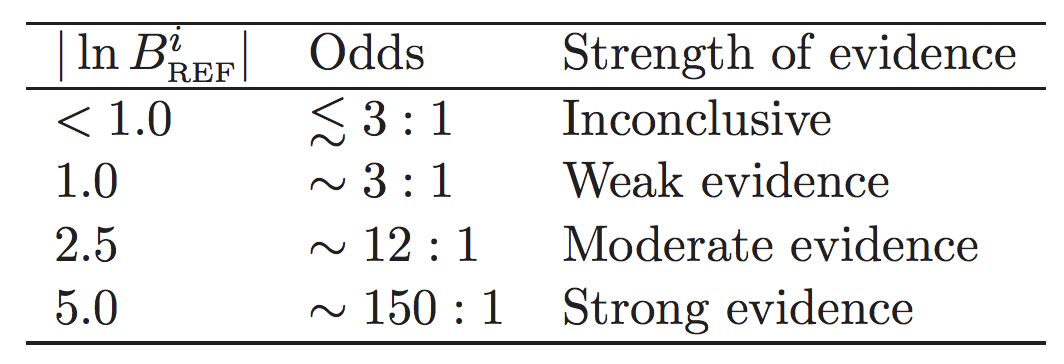

In [25]:
Image("./jeffreys_scale.png", width=500)

## Part II: MCMC Samplers beyond the Metropolis-Hastings (Slides)

- Rejection Sampling
- Gibbs Sampling
- Slice Sampling
- Hamiltonian Monte Carlo
- Ensemble Sampler